# Importing libraries and graphics configurations ###

In [1]:
import numpy as np
import torch
import pandas as pd
import time
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix,f1_score,classification_report
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import train_test_split
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from google.colab import files
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler  
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM 
from tensorflow.keras import layers
from math import sqrt

In [2]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

# Import data ###

In [3]:
# importing visas data
is_pickle_file_available = True
is_running_locally = False

if is_running_locally: 
    file = 'datafile_visas.pkl'
    fileobj = open(file, 'wb')
    pickle.dump(data1, fileobj)
elif (is_pickle_file_available):
    import pickle 
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # https://drive.google.com/file/d/1YTCHoDPfW0SPGTAjXRStwaqrGGzvZmru/view?usp=sharing
    fileDownloaded = drive.CreateFile({'id':'1YTCHoDPfW0SPGTAjXRStwaqrGGzvZmru'})
    file = 'datafile_visas.pkl'
    fileDownloaded.GetContentFile(file)
    fileobj = open(file, 'rb')
    data1 = pickle.load(fileobj)
else :
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    fileDownloaded = drive.CreateFile({'id':'1n0iEUlY_msB-VkssivNDSp6-z_NnBpT4'})
    fileDownloaded.GetContentFile('LCA_Disclosure_Data_FY2022_Q3.csv')
    data = pd.read_csv('LCA_Disclosure_Data_FY2022_Q3.csv', encoding='cp1252')
    columnsNamesArr = data.columns.values
    print(columnsNamesArr)
    data.head()
    ## Deleting unnecessary columns
    data1 = data[['CASE_STATUS','RECEIVED_DATE','DECISION_DATE','EMPLOYER_CITY','EMPLOYER_STATE','WORKSITE_CITY','WORKSITE_STATE','WORKSITE_WORKERS']]
    # Removes SettingWithCopyWarning
    data1 = data1.copy()
    data1['RECEIVED_DATE'] = pd.to_datetime(data1['RECEIVED_DATE'])
    data1['DECISION_DATE'] = pd.to_datetime(data1['DECISION_DATE'])
    import pickle
    file = 'datafile_visas.pkl'
    fileobj = open(file, 'wb')
    pickle.dump(data1, fileobj)
data1.head()

,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,EMPLOYER_CITY,EMPLOYER_STATE,WORKSITE_CITY,WORKSITE_STATE,WORKSITE_WORKERS
0,Certified - Withdrawn,2019-10-01,2022-04-20,WI,WI,Plano,TX,1
1,Certified - Withdrawn,2019-10-01,2022-04-05,RIDGEFIELD PARK,NJ,Plano,TX,1
2,Certified - Withdrawn,2019-10-01,2021-12-01,Hoboken,NJ,Hoboken,NJ,1
3,Certified - Withdrawn,2019-10-02,2022-03-08,Charlotte,NC,Denver,CO,1
4,Certified - Withdrawn,2019-10-02,2021-12-09,Los Alamos,NM,Los Alamos,NM,1


### Clean data ###

In [4]:
data1.head(5)
data_x = data1.copy() # this is the data that will be used for benchmarking. DO NOT EDIT - Dushyant. 

In [5]:
data1.head()

,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,EMPLOYER_CITY,EMPLOYER_STATE,WORKSITE_CITY,WORKSITE_STATE,WORKSITE_WORKERS
0,Certified - Withdrawn,2019-10-01,2022-04-20,WI,WI,Plano,TX,1
1,Certified - Withdrawn,2019-10-01,2022-04-05,RIDGEFIELD PARK,NJ,Plano,TX,1
2,Certified - Withdrawn,2019-10-01,2021-12-01,Hoboken,NJ,Hoboken,NJ,1
3,Certified - Withdrawn,2019-10-02,2022-03-08,Charlotte,NC,Denver,CO,1
4,Certified - Withdrawn,2019-10-02,2021-12-09,Los Alamos,NM,Los Alamos,NM,1


# Data Visualization

###Creating plots to see the trends in various states for Accepted, denied and other types of case status

#### Setup

In [6]:
data_viz = data1.copy() #data to be used for visualizations

In [7]:
data_viz.isna().sum()

CASE_STATUS          0
RECEIVED_DATE        0
DECISION_DATE        0
EMPLOYER_CITY        0
EMPLOYER_STATE      82
WORKSITE_CITY       11
WORKSITE_STATE       0
WORKSITE_WORKERS     0
dtype: int64

In [8]:
##As we have some null values, dropping rows with null values in EMPLOYER_STATE AND WORKSITE_CITY
data_viz.dropna(inplace=True)

In [9]:
def plotmap1(column,value,title):
  demo = data_viz.loc[data_viz['CASE_STATUS'] == value]
  experiment = demo.groupby(column).sum().rename(columns = {'WORKSITE_WORKERS' : 'Count'})
  fig = px.choropleth(experiment,
                      locations=experiment.index, 
                      locationmode="USA-states", 
                      scope="usa",
                      color='Count',
                      color_continuous_scale="Viridis_r"
                      )

  fig.update_layout(
        title_text = title,
        title_font_family="Times New Roman",
        title_font_size = 22,
        title_font_color="black", 
        title_x=0.45,
        showlegend=False 
          )
  fig.show()

In [10]:
def plotmap2(column,title):
  total = {}
  for i in data_viz[column]:
    if i in total:
      total[i] += 1
    else:
      total[i] = 1
  state = []
  values  = []
  for key,value in total.items():
    state.append(key)
    values.append(value)
  demo = pd.DataFrame(list(zip(state, values)),
                columns =[column, 'Count'])

  fig = px.choropleth(demo,
                      locations=column, 
                      locationmode="USA-states", 
                      scope="usa",
                      color='Count',
                      color_continuous_scale="Viridis_r"
                      )

  fig.update_layout(
          title_text = title,
          title_font_family="Times New Roman",
          title_font_size = 22,
          title_font_color="black", 
          title_x=0.45,
          showlegend=False 
            )
  fig.show()

#### Maps by Employer State

In [11]:
values = {'Certified - Withdrawn':"Certified - Withdrawn by Employer State",'Denied':'Denied by Employer State',
          'Certified':'Certified by Employer State','Withdrawn':"Withdrawn by Employer State"}
for key,value in values.items():
  plotmap1('EMPLOYER_STATE',key,value)

#### Maps by Worksite State

In [12]:
values = {'Certified - Withdrawn':"Certified - Withdrawn by Worksite State",'Denied':'Denied by Worksite State',
          'Certified':'Certified by Worksite State','Withdrawn':"Withdrawn by Worksite State"}
for key,value in values.items():
  plotmap1('WORKSITE_STATE',key,value)

#### Applications by Employer State vs Worksite State

In [13]:
plotmap2('EMPLOYER_STATE','Applications by Employer State')
plotmap2('WORKSITE_STATE','Applications by Worksite State')

## Time Taken  (Number of days)

### SETUP

Split the dataset into smaller dataset to be able to more closely visualize the data.

*aside:*

case_status can be = 
1. Certified - Withdrawn
2. Certified
3. Withdrawn
4. Denied

In [14]:
dfDays = pd.DataFrame(columns=['RECEIVED_DATE', 'DECISION_DATE', 'DAYS'])
dfDays['DECISION_DATE'] = data1['DECISION_DATE']
dfDays['RECEIVED_DATE'] = data1['RECEIVED_DATE']
dfDays['DAYS'] = (dfDays['DECISION_DATE'] - dfDays['RECEIVED_DATE']).dt.days

dfDays.sort_values('DAYS')

,RECEIVED_DATE,DECISION_DATE,DAYS
510942,2022-06-30,2022-06-30,0
210142,2022-02-22,2022-02-22,0
30657,2021-10-06,2021-10-06,0
100205,2021-12-02,2021-12-02,0
121645,2021-12-18,2021-12-18,0
...,...,...,...
47,2019-10-08,2022-06-24,990
23,2019-10-03,2022-06-21,992
5,2019-10-02,2022-06-27,999
18,2019-10-03,2022-06-28,999


In [15]:
dfDaysCounts = dfDays['DAYS'].value_counts().sort_index().rename_axis('NUMBER_OF_DAYS').reset_index(name='COUNTS')
print(dfDaysCounts)

     NUMBER_OF_DAYS  COUNTS
0                 0    4464
1                 1    2121
2                 2    1363
3                 3     926
4                 4    1101
..              ...     ...
961             988       1
962             990       1
963             992       1
964             999       2
965            1001       1

[966 rows x 2 columns]


In [16]:
dfDays0_14 = dfDays[dfDays['DAYS'] <= 14]
dfDays0_14 = dfDays0_14[dfDays0_14['DAYS'] > 0]

dfDays15_200 = dfDays[dfDays['DAYS'] <= 200]
dfDays15_200 = dfDays15_200[dfDays15_200['DAYS'] > 14]

dfDaysLess3 = dfDays[dfDays['DAYS'] <= 3]

dfDays4_8 = dfDays[dfDays['DAYS'] <= 8]
dfDays4_8 = dfDays4_8[dfDays4_8['DAYS'] > 3]

dfDays9_14 = dfDays[dfDays['DAYS'] <= 14]
dfDays9_14 = dfDays9_14[dfDays9_14['DAYS'] > 8]

dfDays15_31 = dfDays[dfDays['DAYS'] <= 31]
dfDays15_31 = dfDays15_31[dfDays15_31['DAYS'] > 14]

dfDays32_50 = dfDays[dfDays['DAYS'] <= 50]
dfDays32_50 = dfDays32_50[dfDays32_50['DAYS'] > 31]

dfDays51_70 = dfDays[dfDays['DAYS'] <= 70]
dfDays51_70 = dfDays51_70[dfDays51_70['DAYS'] > 50]

dfDays71_90 = dfDays[dfDays['DAYS'] <= 90]
dfDays71_90 = dfDays71_90[dfDays71_90['DAYS'] > 70]

dfDays91_110 = dfDays[dfDays['DAYS'] <= 110]
dfDays91_110 = dfDays91_110[dfDays91_110['DAYS'] > 90]

dfDays111_130 = dfDays[dfDays['DAYS'] <= 130]
dfDays111_130 = dfDays111_130[dfDays111_130['DAYS'] > 110]

dfDays131_150 = dfDays[dfDays['DAYS'] <= 150]
dfDays131_150 = dfDays131_150[dfDays131_150['DAYS'] > 130]

dfDays151_170 = dfDays[dfDays['DAYS'] <= 170]
dfDays151_170 = dfDays151_170[dfDays151_170['DAYS'] > 150]

In [17]:
import plotly.graph_objects as px
import plotly.express as go

x = dfDaysCounts['NUMBER_OF_DAYS']
y = dfDaysCounts['COUNTS']
  
plot = px.Figure(data=[px.Scatter(x=x,y=y)])
  
plot.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     step="day",
                     stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    )
)
  
plot.show()

### Number of Results per day within 2 weeks

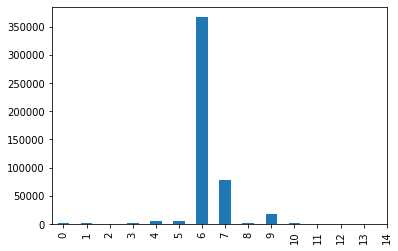

In [18]:
'''
This plots how many people per day get their results within two weeks
''' 
%matplotlib inline
ax = dfDays0_14['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 0, 14
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### Number of Results per day past 2 weeks

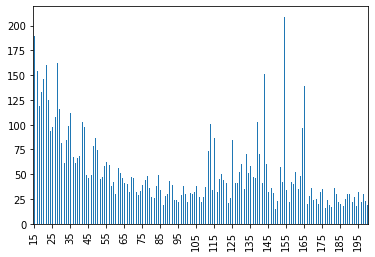

In [19]:
'''
This plots how many people per day get their results past two weeks
''' 
%matplotlib inline
ax = dfDays15_200['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 15, 200
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 10))
ax.set_xticklabels(np.arange(start, end + 1, 10))
plt.show()

## Granular Results per day Plots

### $\mbox{DAYS} \leq 3$

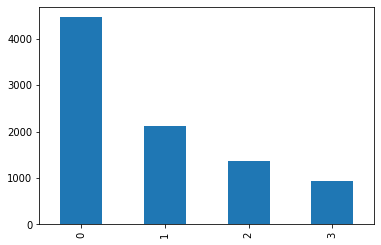

In [20]:
%matplotlib inline
ax = dfDaysLess3['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 0, 3
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $3 < \mbox{DAYS} \leq 8$

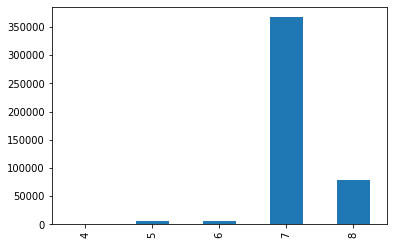

In [21]:
%matplotlib inline
ax = dfDays4_8['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 4, 8
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $ 8 < \mbox{DAYS} \leq 14$

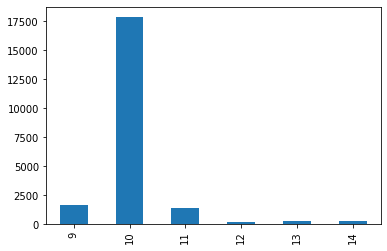

In [22]:
%matplotlib inline
ax = dfDays9_14['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 9, 14
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $14 < \mbox{DAYS} \leq 31$

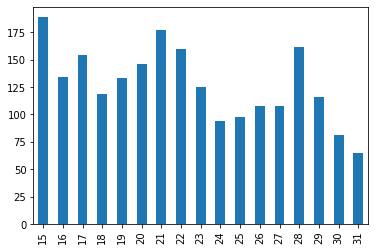

In [23]:
%matplotlib inline
ax = dfDays15_31['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 15, 31
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $31 < \mbox{DAYS} \leq 50$

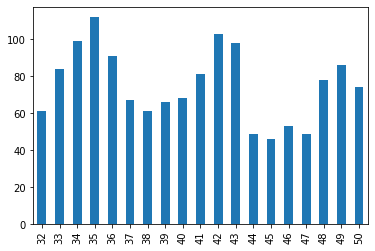

In [24]:
%matplotlib inline
ax = dfDays32_50['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 32, 50
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $50 < \mbox{DAYS} \leq 70$

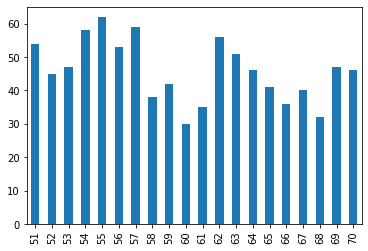

In [25]:
%matplotlib inline
ax = dfDays51_70['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 51, 70
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $70 < \mbox{DAYS} \leq 90$

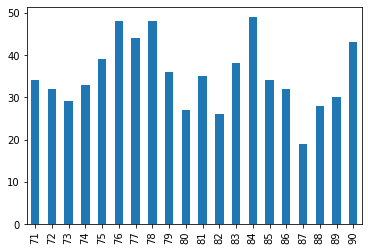

In [26]:
%matplotlib inline
ax = dfDays71_90['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 71, 90
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $90 < \mbox{DAYS} \leq 110$

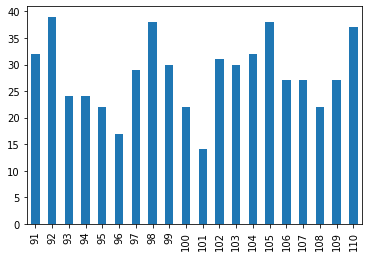

In [27]:
%matplotlib inline
ax = dfDays91_110['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 91, 110
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $110 < \mbox{DAYS} \leq 130$

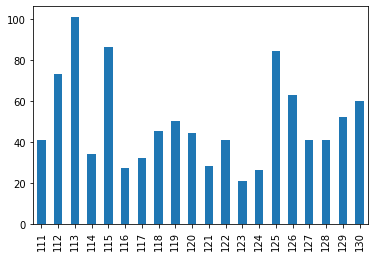

In [28]:
%matplotlib inline
ax = dfDays111_130['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 111, 130
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $130 < \mbox{DAYS} \leq 150$

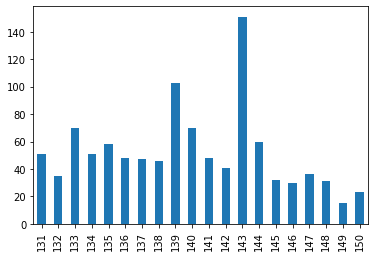

In [29]:
%matplotlib inline
ax = dfDays131_150['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 131, 150
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

### $150 < \mbox{DAYS} \leq 170$

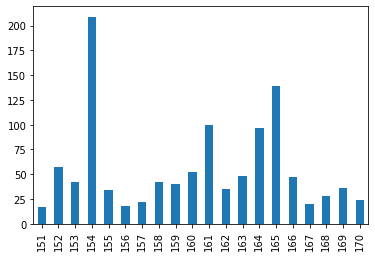

In [30]:
%matplotlib inline
ax = dfDays151_170['DAYS'].value_counts().sort_index().plot(kind='bar')
start, end = 151, 170
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 1))
ax.set_xticklabels(np.arange(start, end + 1, 1))
plt.show()

## Breakdown of results per day

### Setup

In [31]:
dfDaysBreakdown = pd.DataFrame(columns=['RECEIVED_DATE', 'DECISION_DATE', 'DAYS', 'CASE_STATUS'])
dfDaysBreakdown['DECISION_DATE'] = data1['DECISION_DATE']
dfDaysBreakdown['RECEIVED_DATE'] = data1['RECEIVED_DATE']
dfDaysBreakdown['CASE_STATUS'] = data1['CASE_STATUS']
dfDaysBreakdown['DAYS'] = (dfDaysBreakdown['DECISION_DATE'] - dfDaysBreakdown['RECEIVED_DATE']).dt.days

dfDaysBreakdown = dfDaysBreakdown.sort_values('DAYS')
print(dfDaysBreakdown)

       RECEIVED_DATE DECISION_DATE  DAYS            CASE_STATUS
510942    2022-06-30    2022-06-30     0              Withdrawn
210142    2022-02-22    2022-02-22     0              Withdrawn
30657     2021-10-06    2021-10-06     0              Withdrawn
100205    2021-12-02    2021-12-02     0              Withdrawn
121645    2021-12-18    2021-12-18     0              Withdrawn
...              ...           ...   ...                    ...
47        2019-10-08    2022-06-24   990  Certified - Withdrawn
23        2019-10-03    2022-06-21   992  Certified - Withdrawn
5         2019-10-02    2022-06-27   999  Certified - Withdrawn
18        2019-10-03    2022-06-28   999  Certified - Withdrawn
16        2019-10-03    2022-06-30  1001  Certified - Withdrawn

[510943 rows x 4 columns]


In [32]:
# pd.crosstab(dfDaysBreakdown.DAYS,dfDaysBreakdown.CASE_STATUS).replace(0, np.nan).stack().reset_index().rename(columns={0:'Count'})
dfDayTable = pd.crosstab(dfDaysBreakdown.DAYS,dfDaysBreakdown.CASE_STATUS)
dfDayTable.head(10)

CASE_STATUS,Certified,Certified - Withdrawn,Denied,Withdrawn
DAYS,,,,
0,0,0,0,4464
1,0,0,390,1731
2,0,0,701,662
3,0,0,284,642
4,0,0,582,519
5,4983,4,352,541
6,5469,5,286,510
7,366316,675,47,112
8,77558,437,3,3


In [33]:
dfDayTable["sum"] = dfDayTable.sum(axis=1)
dfDayTable = dfDayTable.loc[:,"Certified":"Withdrawn"].div(dfDayTable["sum"], axis=0)
dfDayTable.head(10)

CASE_STATUS,Certified,Certified - Withdrawn,Denied,Withdrawn
DAYS,,,,
0,0.000000,0.000000,0.000000,1.000000
1,0.000000,0.000000,0.183876,0.816124
2,0.000000,0.000000,0.514307,0.485693
3,0.000000,0.000000,0.306695,0.693305
4,0.000000,0.000000,0.528610,0.471390
5,0.847449,0.000680,0.059864,0.092007
6,0.872249,0.000797,0.045614,0.081340
7,0.997728,0.001838,0.000128,0.000305
8,0.994321,0.005602,0.000038,0.000038


### Results

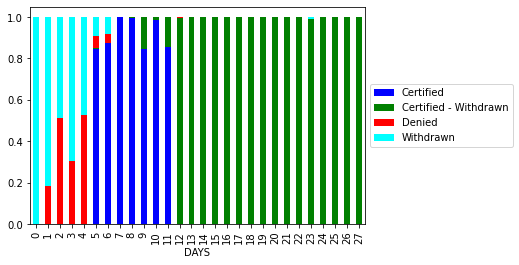

In [34]:
dfDayTable[0:28].plot(kind='bar', stacked=True, color=['blue', 'green', 'red', 'cyan'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

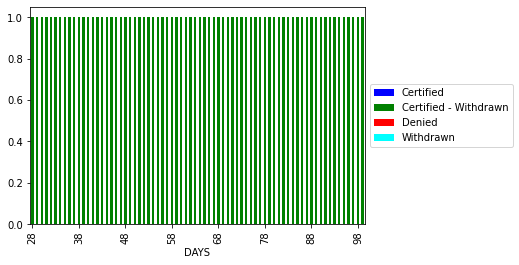

In [35]:
start = 28
end = 100
ax = dfDayTable[start:end].plot(kind='bar', stacked=True, color=['blue', 'green', 'red', 'cyan'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 10))
ax.set_xticklabels(np.arange(start, end + 1, 10))
plt.show()

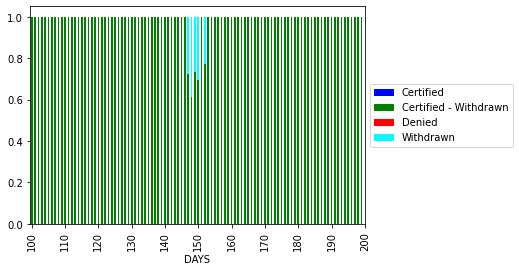

In [36]:
start = 100
end = 200
ax = dfDayTable[start:end].plot(kind='bar', stacked=True, color=['blue', 'green', 'red', 'cyan'])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_ticks(np.arange(0, end - start + 1, 10))
ax.set_xticklabels(np.arange(start, end + 1, 10))
plt.show()

## Acceptance Rate By State

### Setup

In [37]:
data_state = data_viz.groupby(['WORKSITE_STATE', 'CASE_STATUS']).sum()
# data_state.to_csv('state.csv')
data_state.head(8)

WORKSITE_WORKERS
WORKSITE_STATE CASE_STATUS                            
AK             Certified                            91
               Certified - Withdrawn                11
               Denied                                7
               Withdrawn                             2
AL             Certified                          1614
               Certified - Withdrawn               156
               Denied                               22
               Withdrawn                            67

### Helper functions

In [38]:
# Need to reimport for some reason
import plotly.express as px

In [39]:
def plotPerc(curData, title, col='Count'):
    
    fig = px.choropleth(curData,
                      locations="STATE", 
                      locationmode="USA-states", 
                      scope="usa",
                      color=col,
                      color_continuous_scale="Viridis_r"
                      )


    fig.update_layout(
            title_text = title,
            title_font_family="Times New Roman",
            title_font_size = 22,
            title_font_color="black", 
            title_x=0.45,
            showlegend=False 
            )
    fig.show()

In [40]:
def calcPerc(passed, failed):

    def func(x):
        certified = 0
        denied = 0
        for key in passed:
            try:
                certified += data_state.loc[x.name, key].sum()
            except:
                pass
        for key in failed:
            try:
                denied += data_state.loc[x.name, key].sum()
            except:
                pass
        return certified / (certified + denied)

    return func

In [41]:
data_cert_rate = data_state.groupby(['WORKSITE_STATE']).apply(calcPerc(['Certified','Certified - Withdrawn'], ['Denied']))
data_cert_rate = pd.DataFrame({'STATE':data_cert_rate.index, 'Count':data_cert_rate.values})
data_cert_rate.head(5)

,STATE,Count
0,AK,0.935780
1,AL,0.987723
2,AR,0.993654
3,AZ,0.997835
4,CA,0.997658


In [42]:
data_arrival_rate = data_state.groupby(['WORKSITE_STATE']).apply(calcPerc(['Certified'], ['Certified - Withdrawn']))
data_arrival_rate = pd.DataFrame({'STATE':data_arrival_rate.index, 'Count':data_arrival_rate.values})
data_arrival_rate.head(5)

,STATE,Count
0,AK,0.892157
1,AL,0.911864
2,AR,0.938797
3,AZ,0.974615
4,CA,0.975057


### Visualization

In [43]:
'''
This plots the percentage of applicants that end up being certified 
and don't withdraw their application
This will be important to the person, since this answers the question of:
"What are my chances of being accepted?"
'''
plotPerc(data_cert_rate, 'Certification Rate by State')
print("What percentage of applicants are accepted?")

What percentage of applicants are accepted?


In [44]:
'''
This plots the percentage of applicants that are certified 
and don't withdraw their application.
This will be important to the state, since this answers the question of:
"If we accept this person, what is the likelyhood they come?"
'''
plotPerc(data_arrival_rate, 'Application to Arrival Conversion Rate by State')
print("What percentage of applicants that are accepted don't withdraw their applicantation?")

What percentage of applicants that are accepted don't withdraw their applicantation?


# Benchmarking using Logistic CLASSification

In the next cells , we are going to prepare the data and use the Linear and Logistic regression on it to set a benchmark to compare when we apply deep learning on it. 

## Prepping the data

### Getting some useful preprocessing functions beforehand

In [45]:
# we will be working on the benchmarking dataframe data_x
# FUNCTIONS THAT MIGHT BE USEFUL
def modify_label_encoder(x_tr, x_te , lab_col): 
    for i in lab_col:
        le = LabelEncoder()
        #print(i, np.unique(x_tr[:, i]))
        #print(np.unique(x_te[:, i]))
        #print(np.unique(X_q[:,i]))
        le.fit(np.concatenate((x_tr[:,i] , x_te[:,i] ) , axis = 0))
        x_tr[:,i] = le.transform(x_tr[:,i])
        #print('transform 1')
        x_te[:,i] = le.transform(x_te[:,i])
        #print('transform 2')

        

def drop_the_columns(x_tr, x_te,  del_col): 
    adj = 0 
    for i in del_col: 
        x_tr = np.concatenate((x_tr[:, :i-adj] , x_tr[:, i-adj+1:]), axis =1)
    

def missing_values_fix(x_tr, x_te,   col, strategy):
    #maybe leave the parts where consts are used, mainly use only mean or median strategy
    for i in col:
        print(i)
        si = SimpleImputer(strategy = strategy[i])
        x_tr[:,i] = si.fit_transform(x_tr[:, i].reshape(-1,1)).reshape(-1,)
        x_te[:,i] = si.transform(x_te[:, i].reshape(-1,1)).reshape(-1,)




In [46]:
# remove the rows with values certified withdrawn or withreawn 
# TODO - Dushyant. 

# fidning the rows where the value of data_x[:, 0] is 'C' or 'D'

# This cell can be used to filter out unwanted data - we are not doing it becuase it's not needed for now.
'''
i = []
for j in range(len(data_x)): 
  if data_x.iloc[j, 0] == 'Certified' or data_x.iloc[j, 0] == 'Denied':
    i.append(j)

data_new = data_x.iloc[i, :]
print(len(data_new))
print(data_new.head())
'''

"\ni = []\nfor j in range(len(data_x)): \n  if data_x.iloc[j, 0] == 'Certified' or data_x.iloc[j, 0] == 'Denied':\n    i.append(j)\n\ndata_new = data_x.iloc[i, :]\nprint(len(data_new))\nprint(data_new.head())\n"

In [47]:
data_x.iloc[1, 0]

'Certified - Withdrawn'

In [48]:
train_data_y = data_x.iloc[:, 0]
train_data = data_x.iloc[:, 1:]
print(train_data.head())
train_data['r_year'] = train_data['RECEIVED_DATE'].map(lambda x: x.year)
train_data['r_month'] = train_data['RECEIVED_DATE'].map(lambda x: x.month)
train_data['r_day'] = train_data['RECEIVED_DATE'].map(lambda x: x.day)
#train_data['d_year'] = train_data['DECISION_DATE'].map(lambda x: x.year)
#train_data['d_month'] = train_data['DECISION_DATE'].map(lambda x: x.month)
#train_data['d_day'] = train_data['DECISION_DATE'].map(lambda x: x.day)
train_data = train_data.drop(columns = ['RECEIVED_DATE', 'DECISION_DATE'])
print(train_data.shape)
print(train_data_y.shape)
print(train_data.head())

  RECEIVED_DATE DECISION_DATE    EMPLOYER_CITY EMPLOYER_STATE WORKSITE_CITY  \
0    2019-10-01    2022-04-20               WI             WI         Plano   
1    2019-10-01    2022-04-05  RIDGEFIELD PARK             NJ         Plano   
2    2019-10-01    2021-12-01          Hoboken             NJ       Hoboken   
3    2019-10-02    2022-03-08        Charlotte             NC        Denver   
4    2019-10-02    2021-12-09       Los Alamos             NM    Los Alamos   

  WORKSITE_STATE  WORKSITE_WORKERS  
0             TX                 1  
1             TX                 1  
2             NJ                 1  
3             CO                 1  
4             NM                 1  
(510943, 8)
(510943,)
     EMPLOYER_CITY EMPLOYER_STATE WORKSITE_CITY WORKSITE_STATE  \
0               WI             WI         Plano             TX   
1  RIDGEFIELD PARK             NJ         Plano             TX   
2          Hoboken             NJ       Hoboken             NJ   
3        Charlott

In [49]:
train_data.sample(frac = 0.1)

,EMPLOYER_CITY,EMPLOYER_STATE,WORKSITE_CITY,WORKSITE_STATE,WORKSITE_WORKERS,r_year,r_month,r_day
299788,Chicago,IL,Chicago,IL,1,2022,4,7
216445,Pleasanton,CA,Pleasanton,CA,1,2022,2,25
473229,Chicago,IL,Columbus,OH,1,2022,6,13
173711,Iselin,NJ,Reston,VA,1,2022,2,1
212186,Menlo Park,CA,Menlo Park,CA,1,2022,2,23
...,...,...,...,...,...,...,...,...
362834,Boston,MA,Boston,MA,1,2022,5,3
411869,Scottsdale,AZ,Little Elm,TX,1,2022,5,20
394484,Seattle,WA,Arlington,VA,1,2022,5,16
159284,Reston,VA,Reston,VA,1,2022,1,21


In [50]:
train_data_y.sample(frac = 0.1)

328076    Certified
352448    Certified
108389    Certified
319586    Certified
73902     Certified
            ...    
270166    Certified
324470    Certified
19184     Certified
434467    Certified
326965    Certified
Name: CASE_STATUS, Length: 51094, dtype: object

In [51]:
# value count code 
del_col = []

for i in range(len(train_data.columns)): 
    print(train_data.columns[i] , train_data.iloc[:, i].nunique(dropna = True) , train_data.iloc[:, i].nunique(dropna = False) , train_data.dtypes[i]  , '\n')
    if (train_data.dtypes[i] == object and train_data.iloc[:, i].nunique() > len(train_data)/30): 
        # then this has to be removed 
        del_col.append(train_data.columns[i])

print(del_col)
print(len(del_col))

train_data = train_data.drop(columns = del_col)
train_data

EMPLOYER_CITY 7711 7711 object 

EMPLOYER_STATE 56 57 object 

WORKSITE_CITY 14035 14036 object 

WORKSITE_STATE 55 55 object 

WORKSITE_WORKERS 49 49 int64 

r_year 4 4 int64 

r_month 12 12 int64 

r_day 31 31 int64 

[]
0


,EMPLOYER_CITY,EMPLOYER_STATE,WORKSITE_CITY,WORKSITE_STATE,WORKSITE_WORKERS,r_year,r_month,r_day
0,WI,WI,Plano,TX,1,2019,10,1
1,RIDGEFIELD PARK,NJ,Plano,TX,1,2019,10,1
2,Hoboken,NJ,Hoboken,NJ,1,2019,10,1
3,Charlotte,NC,Denver,CO,1,2019,10,2
4,Los Alamos,NM,Los Alamos,NM,1,2019,10,2
...,...,...,...,...,...,...,...,...
510938,San Francisco,CA,SAN FRANCISCO,CA,1,2022,6,28
510939,San Francisco,CA,SAN FRANCISCO,CA,1,2022,6,28
510940,Secaucus,NJ,New York,NY,1,2022,6,29
510941,Austin,TX,Austin,TX,1,2022,6,29


In [52]:
# Finding the best strategies for the data to altered and preprocessed for Learning

strategy = {}

for i in range(len(train_data.columns)): 
    print(train_data.columns[i] , train_data.iloc[:, i].nunique(dropna = True) , train_data.iloc[:, i].nunique(dropna = False) ,  train_data.dtypes[i]  , '\n')
    if (train_data.iloc[:, i].nunique(dropna = True) != train_data.iloc[:, i].nunique(dropna = False) and train_data.dtypes[i] == object) : 
        strategy[i] = 'most_frequent'
    if (train_data.iloc[:, i].nunique(dropna = True) != train_data.iloc[:, i].nunique(dropna = False) and train_data.dtypes[i] != object) : 
        strategy[i] = 'median'
print(strategy)

EMPLOYER_CITY 7711 7711 object 

EMPLOYER_STATE 56 57 object 

WORKSITE_CITY 14035 14036 object 

WORKSITE_STATE 55 55 object 

WORKSITE_WORKERS 49 49 int64 

r_year 4 4 int64 

r_month 12 12 int64 

r_day 31 31 int64 

{1: 'most_frequent', 2: 'most_frequent'}


### Converting dataset into numpy 


In [53]:
y_tr = train_data_y.values
x_tr = train_data.iloc[:, :].values

In [54]:
np.unique(train_data_y, return_counts=True)

(array(['Certified', 'Certified - Withdrawn', 'Denied', 'Withdrawn'],
       dtype=object), array([474513,  24549,   2650,   9231]))

In [55]:
TEST_SIZE = 0.1
# DO NOT CHANGE
x_tr, x_te, y_tr, y_te = train_test_split(x_tr, y_tr, test_size = TEST_SIZE)

### Correcting missing values using strategies decided earliar

In [56]:

print(x_tr.shape)
print(x_tr)
# DO NOT CHANGE
missing_values_fix(x_tr, x_te,  col = strategy.keys() , strategy = strategy )

(459848, 8)
[['Dallas' 'TX' 'Dallas' ... 2021 12 15]
 ['FREMONT' 'CA' 'NEWARK' ... 2022 5 17]
 ['Troy' 'MI' 'Framingham' ... 2022 6 3]
 ...
 ['Boston' 'MA' 'San Francisco' ... 2022 5 17]
 ['Normal' 'IL' 'Normal' ... 2022 4 5]
 ['RICHARDSON' 'TX' 'New York' ... 2022 5 24]]
1
2


In [57]:
print(x_tr[:5, :])


[['Dallas' 'TX' 'Dallas' 'TX' 1 2021 12 15]
 ['FREMONT' 'CA' 'NEWARK' 'CA' 1 2022 5 17]
 ['Troy' 'MI' 'Framingham' 'MA' 3 2022 6 3]
 ['AUSTIN' 'TX' 'Austin' 'TX' 1 2022 3 15]
 ['Jersey City' 'NJ' 'BOTHELL' 'WA' 1 2022 3 10]]


### Label encoding 

In [58]:

le_col = []
for i in range(len(train_data.columns)): 
    print(train_data.columns[i] , train_data.iloc[:, i].nunique(dropna = True) , train_data.iloc[:, i].nunique(dropna = False) , train_data.dtypes[i]  , '\n')
    if (train_data.dtypes[i] == object): 
        # label encoding is required 
        le_col.append(i)

print(le_col)
print(len(le_col))


le_col = le_col.copy()
modify_label_encoder(x_tr, x_te, le_col)

print(x_tr[:5,:])

EMPLOYER_CITY 7711 7711 object 

EMPLOYER_STATE 56 57 object 

WORKSITE_CITY 14035 14036 object 

WORKSITE_STATE 55 55 object 

WORKSITE_WORKERS 49 49 int64 

r_year 4 4 int64 

r_month 12 12 int64 

r_day 31 31 int64 

[0, 1, 2, 3]
4
[[1755 47 3771 46 1 2021 12 15]
 [2313 4 8581 4 1 2022 5 17]
 [6869 24 4975 20 3 2022 6 3]
 [278 47 1650 46 1 2022 3 15]
 [3292 34 1842 51 1 2022 3 10]]


In [59]:
# label encoding for y_tr
le = LabelEncoder()

le.fit(np.concatenate((y_tr , y_te ) , axis = 0))
y_tr = le.transform(y_tr)
#print('transform 1')
y_te = le.transform(y_te)
#print('transform 2')
print(np.max(y_te))


3


### Applying the models finally

In [60]:
test_models_regression = { 'logistic_classification': () , 'deep_learning_RNN': ()}



'''
Using logistic regressions to estimate acceptance rate
'''

if "logistic_classification" in test_models_regression : 
    from sklearn.linear_model import LogisticRegression
    linr = LogisticRegression(max_iter = 10000, multi_class='multinomial')
    SS = StandardScaler()
    x_tr_st = SS.fit_transform(x_tr)
    x_te_st = SS.transform(x_te)

    print('\nlogistics classification results ::\n')
    tune_param = {
        
    }
    #linr = GridSearchCV( LogisticRegression(), tune_param )
    linr.fit(x_tr_st, y_tr)
    #print('Best Parameters results :' , clf.cv_results_)
    #print('best Parameteres: ' , linr.best_params_)
    
    y_p_tr = linr.predict(x_tr_st)
    y_p_te = linr.predict(x_te_st)
    

    from sklearn.metrics import mean_squared_error
    
    print('train :' , mean_squared_error(y_tr, y_p_tr) )
    print('test :' , mean_squared_error(y_te, y_p_te))
    print('model score : ', linr.score(x_te_st, y_te))
    from sklearn.metrics import r2_score, confusion_matrix
    conf_mat_tr =confusion_matrix(y_tr, y_p_tr) 
    conf_mat_te =confusion_matrix(y_te, y_p_te)
    print(confusion_matrix(y_tr, y_p_tr))
    print(confusion_matrix(y_te, y_p_te))
    print('r2_score_test :' ,r2_score(y_te, y_p_te))
    test_models_regression['logistic_classification'] =  (linr , y_p_te,  mean_squared_error(y_te, y_p_te) )



logistics classification results ::

train : 0.20339112054417982
test : 0.20684998532146004
model score :  0.9565515216753107
[[427038      0      0      0]
 [  9632  12500      0      0]
 [  2402      0      0      0]
 [  8237     39      0      0]]
[[47475     0     0     0]
 [ 1017  1400     0     0]
 [  248     0     0     0]
 [  948     7     0     0]]
r2_score_test : 0.06886009940259619


### Performance of Logistic classification model

In [61]:
'''
let's test how good we performed. 
our performance matrix = correctly classified vs incorrectly classified. 
'''


PERFORMANCE_OF_LINEAR_REGRESSION_TRAINING = np.sum(np.diag(conf_mat_tr)) / np.sum(conf_mat_tr)
PERFORMANCE_OF_LINEAR_REGRESSION_TESTING = np.sum(np.diag(conf_mat_te)) / np.sum(conf_mat_te)
print("PERFORMANCE_OF_LOGISTIC_REGRESSION_TRAINING = ", PERFORMANCE_OF_LINEAR_REGRESSION_TRAINING)
print("PERFORMANCE_OF_LOGISTIC_REGRESSION_TESTING =  ", PERFORMANCE_OF_LINEAR_REGRESSION_TESTING)
print()

print(classification_report(y_te, y_p_te, target_names = ['C' , 'CW' , 'W', 'D'], zero_division = 0 ))

PERFORMANCE_OF_LOGISTIC_REGRESSION_TRAINING =  0.9558332318505245
PERFORMANCE_OF_LOGISTIC_REGRESSION_TESTING =   0.9565515216753107

              precision    recall  f1-score   support

           C       0.96      1.00      0.98     47475
          CW       1.00      0.58      0.73      2417
           W       0.00      0.00      0.00       248
           D       0.00      0.00      0.00       955

    accuracy                           0.96     51095
   macro avg       0.49      0.39      0.43     51095
weighted avg       0.93      0.96      0.94     51095



### Comment on Logistic Regression Results

As our data is skewed with Certified and Cetified Withdrawn entries, the precision, recall and F1-score for Withdrawn and Denied is coming to be 0.

# Implementing CNN

### Implementing the model

In [62]:
print("Is Cuda Available:", torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Is Cuda Available: True
Device: cuda:0


In [63]:
# cleaned data - x_tr, y_tr, x_te, y_te
# this is time series data 
print(x_tr.shape, y_tr.shape, y_tr[:5], x_tr[:5])

SS = StandardScaler()
x_tr_st = SS.fit_transform(x_tr)
x_te_st = SS.transform(x_te)

x_tr_tensor = torch.tensor(x_tr_st.astype(np.float64), dtype = torch.float64).to(device)
y_tr_tensor = torch.tensor(y_tr.astype(np.float64), dtype = torch.float64).to(device)
y_tr_tensor_oh = F.one_hot(y_tr_tensor.to(torch.int64)).to(torch.float64)
x_te_tensor = torch.tensor(x_te_st.astype(np.float64), dtype = torch.float64).to(device)
    
print("Training input size:", x_tr_tensor.size())
print("Training label size:", y_tr_tensor.size())

(459848, 8) (459848,) [0 0 0 0 2] [[1755 47 3771 46 1 2021 12 15]
 [2313 4 8581 4 1 2022 5 17]
 [6869 24 4975 20 3 2022 6 3]
 [278 47 1650 46 1 2022 3 15]
 [3292 34 1842 51 1 2022 3 10]]
Training input size: torch.Size([459848, 8])
Training label size: torch.Size([459848])


In [64]:
class approved_predictor(nn.Module): 
    def __init__(self, d_date=True): 
        super(approved_predictor, self).__init__()

        self.d_date = d_date
        inputSize = 11 if d_date else 8

        self.model = nn.Sequential(
            nn.Linear(inputSize, 16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if self.d_date == False:
            x = x[:, :8]
        return self.model(x)

In [65]:
def train(model, points, labels, learningRate=0.01, MAX_iter=10000, printEvery=1000):
    loss = nn.MSELoss()
    losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

    points = points.float()
    labels = labels.float()

    for itr in range(MAX_iter):

        # Clear gradient buffers 
        optimizer.zero_grad()

        # Create the iterations batch and labels
        rand_vec = torch.randint(0, points.size()[0] - 2, size = (batch_size,))
        batch = points.float()[rand_vec,:]
        batch_labels = labels.float()[rand_vec]

        # get output from the model, given the inputs
        outputs = model(batch)

        # get loss for the predicted output
        lossvalue = loss(outputs, batch_labels)
        if itr%100 == 0:
          losses.append(lossvalue.item())

        # get gradients w.r.t to parameters
        lossvalue.backward()
        
        optimizer.step()

        if itr % printEvery == 0:
            print("Epoch {}: loss={:.5f}".format(itr/100, lossvalue.item()))
        
    return model, losses

### Plotting the performance of the deep learning model to make predictions

approved_predictor(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=8, bias=True)
    (9): ReLU()
    (10): Linear(in_features=8, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=4, bias=True)
    (13): Softmax(dim=1)
  )
)
Epoch 0.0: loss=0.19932
Epoch 10.0: loss=0.02002
Epoch 20.0: loss=0.02080
Epoch 30.0: loss=0.02056
Epoch 40.0: loss=0.01898
Epoch 50.0: loss=0.02246
Epoch 60.0: loss=0.01875
Epoch 70.0: loss=0.01958
Epoch 80.0: loss=0.02058
Epoch 90.0: loss=0.02063


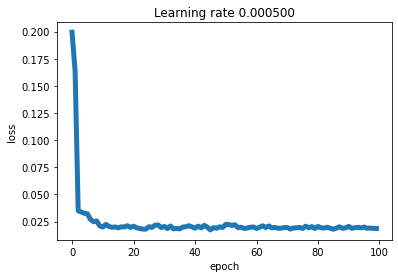

Training Confusion Matrix
[[426995     43      0      0]
 [  7805  14327      0      0]
 [  2402      0      0      0]
 [  8237     39      0      0]]

Testing Confusion Matrix
[[47466     9     0     0]
 [  810  1607     0     0]
 [  248     0     0     0]
 [  948     7     0     0]]

Accuracy of the model in MSE:  0.20297485076817692
PERFORMANCE_OF_CNN_REGRESSION_TRAINING =  0.9597127746559733
PERFORMANCE_OF_CNN_REGRESSION_TESTING =   0.9604266562285938

              precision    recall  f1-score   support

           C       0.96      1.00      0.98     47475
          CW       0.99      0.66      0.80      2417
           W       0.00      0.00      0.00       248
           D       0.00      0.00      0.00       955

    accuracy                           0.96     51095
   macro avg       0.49      0.42      0.44     51095
weighted avg       0.94      0.96      0.95     51095



In [67]:
if "deep_learning_RNN" in test_models_regression : 
    
    approved_pred = approved_predictor(False).to(device)
    
    batch_size, lr = 10000, 5e-4

    print(approved_pred)
        
    approved_pred, losses = train(approved_pred, x_tr_tensor, y_tr_tensor_oh, learningRate=lr)

    plt.plot(losses)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Learning rate %f"%(lr))
    plt.show()


    y_p_te = np.around( np.array(torch.argmax(approved_pred(x_te_tensor.float()) , dim=1).detach().cpu()))
    y_p_tr = np.around( np.array(torch.argmax(approved_pred(x_tr_tensor.float()), dim=1).detach().cpu()))

    conf_mat_tr = confusion_matrix(y_tr, y_p_tr) 
    conf_mat_te = confusion_matrix(y_te, y_p_te)
    print("Training Confusion Matrix")
    print(confusion_matrix(y_tr, y_p_tr))
    print("\nTesting Confusion Matrix")
    print(confusion_matrix(y_te, y_p_te))

    print("\nAccuracy of the model in MSE: " , mean_squared_error(y_te, y_p_te) )
    #print('r2_score_test :' ,r2_score(y_te, y_p_te))
    
    test_models_regression['deep_learning_RNN'] =  (approved_pred , y_p_te,  mean_squared_error(y_te, y_p_te) )


    '''
    let's test how good we performed. 
    our performance matrix = correctly classified vs incorrectly classified. 
    '''
    
    PERFORMANCE_OF_LINEAR_REGRESSION_TRAINING = np.sum(np.diag(conf_mat_tr)) / np.sum(conf_mat_tr)
    PERFORMANCE_OF_LINEAR_REGRESSION_TESTING = np.sum(np.diag(conf_mat_te)) / np.sum(conf_mat_te)
    print("PERFORMANCE_OF_CNN_REGRESSION_TRAINING = ", PERFORMANCE_OF_LINEAR_REGRESSION_TRAINING)
    print("PERFORMANCE_OF_CNN_REGRESSION_TESTING =  ", PERFORMANCE_OF_LINEAR_REGRESSION_TESTING)
    print()

    print(classification_report(y_te, y_p_te, target_names = ['C' , 'CW' , 'W', 'D'], zero_division = 0 ))
    

# Implementing the RNN - LSTM Model

## Preparing the data

In [68]:
# Dropping rows with missing values
data_x.dropna(inplace = True)

In [69]:
# Converting Decision date and received date to date time
data_x['DECISION_DATE'] = pd.to_datetime(data_x['DECISION_DATE'])
data_x['RECEIVED_DATE'] = pd.to_datetime(data_x['RECEIVED_DATE'])

# Sorting by decision date
data_x.sort_values(by = ['DECISION_DATE'],inplace = True)

#Dropping columns not needed in LSTM
data_x.drop(['RECEIVED_DATE','EMPLOYER_CITY','EMPLOYER_STATE','WORKSITE_CITY','WORKSITE_STATE','WORKSITE_WORKERS'],axis = 1,inplace = True)

In [70]:
# Adding total visas processed per data to dataframe
trial = {}
sum = 0
for i in data_x['DECISION_DATE']:
  if i not in trial:
    trial[i] = 1
  else:
    trial[i] += 1

for k,v in trial.items():
  data_x.loc[data_x['DECISION_DATE'] == k, 'TOTAL_COUNT'] = int(v)

In [71]:
#Restting the index to get correct dates
data_x.reset_index(drop=True, inplace=True)

## Building LSTM Model

In [72]:
def data_prep_lstm(case):
  # Creating a copy of the dataset
  data_x_copy = data_x.copy()

  # Filtering to particular case status
  certified = data_x_copy[data_x_copy["CASE_STATUS"] == case]

  #Finding percentage of case status with respect to total visas given that day
  certified1 = {}
  sum = 0
  for i in certified['DECISION_DATE']:
    if i not in certified1:
      certified1[i] = 1
    else:
      certified1[i] += 1
  for k,v in certified1.items():
    certified.loc[certified['DECISION_DATE'] == k, 'COUNT'] = int(v)
  
  #Dropping duplicate decision dates
  certified = certified.drop_duplicates(subset=['DECISION_DATE'], keep='last')

  #Finding percentage
  certified['Percentage'] = (certified['COUNT']/certified['TOTAL_COUNT'])*100

  #Dropping unrequired columns
  certified.drop(['CASE_STATUS','TOTAL_COUNT','COUNT'],axis = 1,inplace = True)

  #Setting decision date as the index
  certified.reset_index(drop=True, inplace=True)
  certified.set_index('DECISION_DATE',inplace = True)

  #Adding missing dates
  new_date_range = pd.date_range(start=data_x['DECISION_DATE'][0], end=data_x['DECISION_DATE'].iat[-1], 
                                 freq="D")
  certified = certified.reindex(new_date_range, fill_value=np.NaN)

  #Filling missing values for newly added dates by mean
  certified = certified.fillna(certified.mean())

  return certified

In [73]:
def apply_lstm(case):
  trial1 = data_prep_lstm(case)

  ##CReating training and test sets
  train = trial1.iloc[:int(len(trial1)*0.9)]
  test = trial1.iloc[int(len(trial1)*0.9):]

  #Using MinMaxScaler to get values in range
  scaler = MinMaxScaler()
  scaler.fit(train)
  scaled_train = scaler.transform(train)
  scaled_test = scaler.transform(test)

  #Building the model
  n_input = 12
  n_features = 1
  generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

  # define model
  model = Sequential()
  model.add(layers.LSTM(100, return_sequences=True, input_shape=(n_input, n_features)))
  model.add(layers.LSTM(100, return_sequences=True))
  model.add(layers.LSTM(100, return_sequences=False))
  model.add(layers.Dense(25))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')

  #Fitting the model
  model.fit(generator,epochs=50)

  #Plotting a plot for the loss
  loss_per_epoch = model.history.history['loss']
  print(plt.plot(range(len(loss_per_epoch)),loss_per_epoch))

  #Getting the testset values
  test_predictions = []

  first_eval_batch = scaled_train[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(len(test)):
      
      # get the prediction value for the first batch
      current_pred = model.predict(current_batch)[0]
      
      # append the prediction into the array
      test_predictions.append(current_pred) 
      
      # use the prediction to update the batch and remove the first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  
  #Getting the predictions
  true_predictions = scaler.inverse_transform(test_predictions)

  #Adding predictions to test
  test['Predictions'] = true_predictions

  #Printing the results
  print(test.plot(figsize=(14,5)))

  #Printing the RSME value
  rmse=sqrt(mean_squared_error(test['Percentage'],test['Predictions']))
  print("RSME: ",rmse)
  print("\n")

## Appling the LSTM model to various visa results

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/50
233/233 [==============================] - 7s 6ms/step - loss: 0.0945
Epoch 2/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0760
Epoch 3/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0577
Epoch 4/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0638
Epoch 5/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0569
Epoch 6/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0531
Epoch 7/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0500
Epoch 8/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0482
Epoch 9/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0483
Epoch 10/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0461
Epoch 11/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0440
Epoch 12/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0451
Epoch 13/50
233/233 [====

<ipython-input-73-e72ed7e8f2e3>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



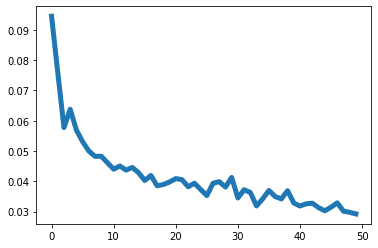

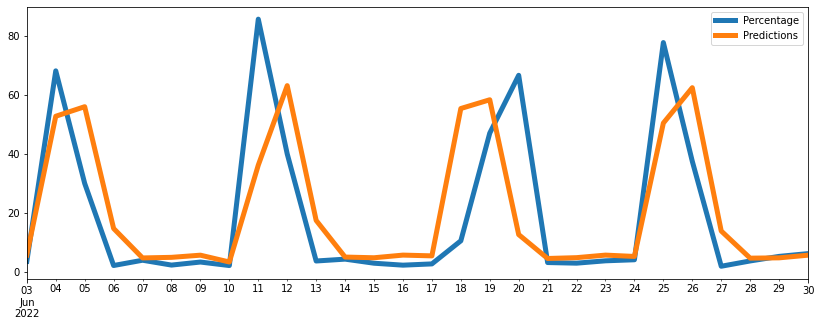

In [74]:
apply_lstm("Certified - Withdrawn")

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/50
233/233 [==============================] - 6s 6ms/step - loss: 0.0524
Epoch 2/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0485
Epoch 3/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0423
Epoch 4/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0417
Epoch 5/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0401
Epoch 6/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0387
Epoch 7/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0397
Epoch 8/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0378
Epoch 9/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0369
Epoch 10/50
233/233 [==============================] - 2s 7ms/step - loss: 0.0376
Epoch 11/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0374
Epoch 12/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0384
Epoch 13/50
233/233 [====

<ipython-input-73-e72ed7e8f2e3>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



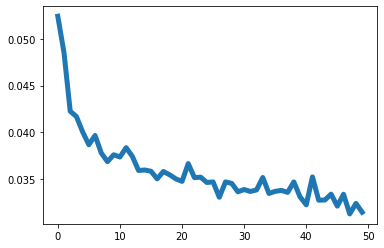

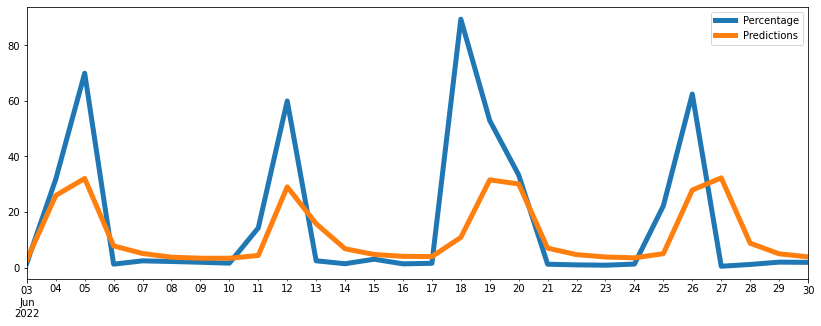

In [75]:
apply_lstm("Withdrawn")

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/50
233/233 [==============================] - 6s 7ms/step - loss: 0.0442
Epoch 2/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0358
Epoch 3/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0304
Epoch 4/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0317
Epoch 5/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0292
Epoch 6/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0292
Epoch 7/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0287
Epoch 8/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0277
Epoch 9/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0284
Epoch 10/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0281
Epoch 11/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0291
Epoch 12/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0274
Epoch 13/50
233/233 [====

<ipython-input-73-e72ed7e8f2e3>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



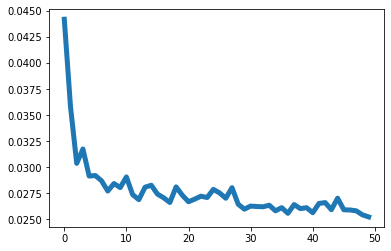

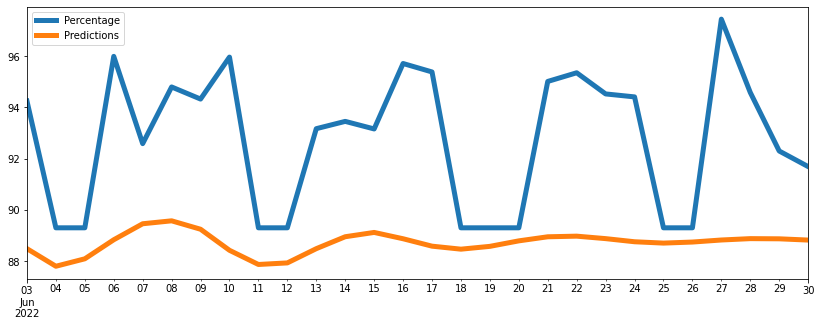

In [76]:
apply_lstm("Certified")

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/50
233/233 [==============================] - 5s 6ms/step - loss: 0.0308
Epoch 2/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0271
Epoch 3/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0274
Epoch 4/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0272
Epoch 5/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0266
Epoch 6/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0267
Epoch 7/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0261
Epoch 8/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0263
Epoch 9/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0274
Epoch 10/50
233/233 [==============================] - 2s 6ms/step - loss: 0.0255
Epoch 11/50
233/233 [==============================] - 2s 8ms/step - loss: 0.0260
Epoch 12/50
233/233 [==============================] - 1s 6ms/step - loss: 0.0260
Epoch 13/50
233/233 [====

<ipython-input-73-e72ed7e8f2e3>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



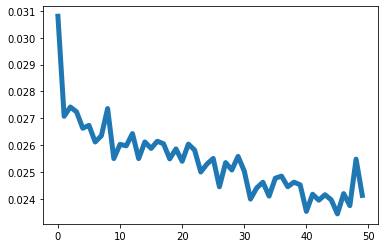

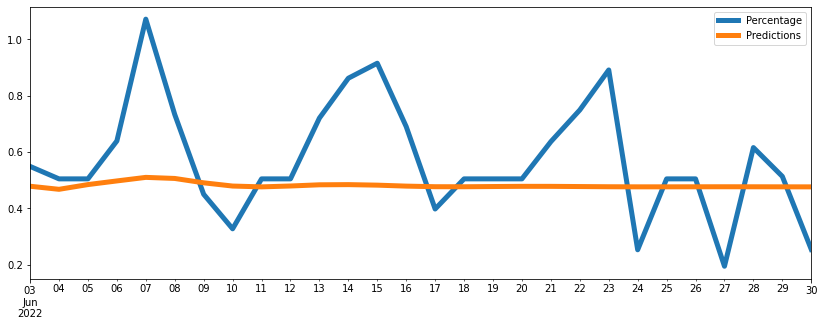

In [77]:
apply_lstm("Denied")